## Agentic RAG
* Retrieve , Generate, Rewrite, Validation
* 아래 흐름에서 END 로 빠지지 않도록 중간에 Tool node 부터 이어지는 구조를 활용함
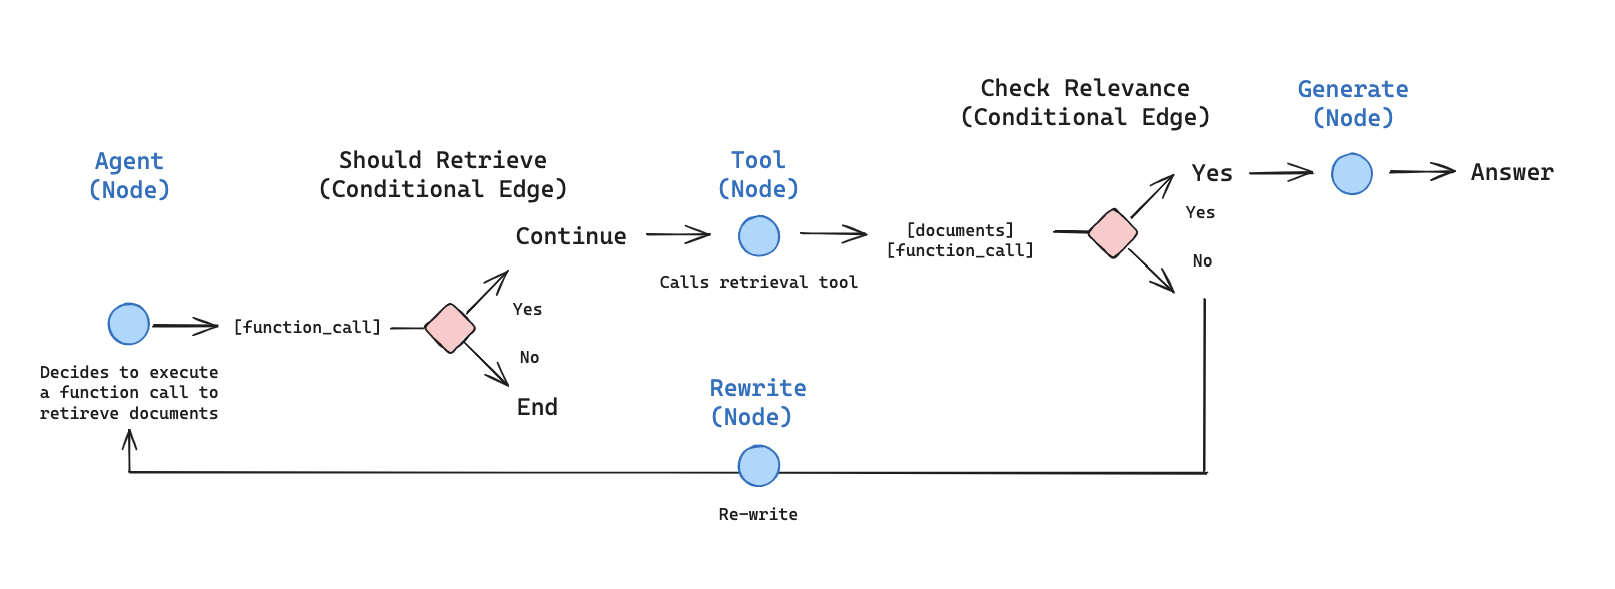

In [1]:
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

from langchain_chroma import Chroma

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str
    
graph_builder = StateGraph(AgentState)

In [3]:
def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    docs = retriever.invoke(query)
    return {'context':docs}

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = 'gpt-4o')

* 이전과는 다르게 generate , rewrite, validation 각각의 prompt 가 필요함

In [5]:
from langchain import hub
generate_prompt = hub.pull('rlm/rag-prompt')

def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | llm
    response = rag_chain.invoke({'question': query , 'context': context})
    return {'answer':response}

In [6]:
# 질문과 문서 간 연관도/유사도 score
# type 이 node 를 return 한다는 것을 선언해줘야 함

from typing import Literal
relevance_doc_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate','rewrite']:
    query = state['query']
    context = state['context']
    print(f'context == {context}')
    
    doc_relevance_chain = relevance_doc_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    print(f'doc relevance response : {response}')
    if response['Score']==1:
        return 'generate'
    
    return 'rewrite'

In [7]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']
rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
사전: {dictionary}
질문: {{query}}                             
""")

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query':query})
    return {'query' : response}

In [8]:
graph_builder.add_node('retrieve',retrieve)
graph_builder.add_node('generate',generate)
graph_builder.add_node('rewrite',rewrite)

In [9]:
from langgraph.graph import START, END
graph_builder.add_edge(START,'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite','retrieve')
graph_builder.add_edge('generate', END)

In [10]:
graph = graph_builder.compile()

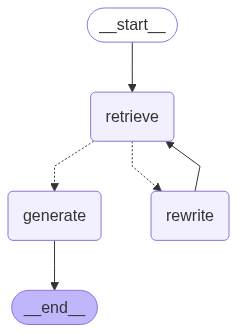

In [11]:
graph

In [12]:
initial_state = {'query': '연봉 5천만원 세금'}
graph.invoke(initial_state)

context == [Document(metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'), Document(metadata={'source': './documents/income_tax.txt'}, page_content='1. 근속연수에 따라 정한 다음의 금액\n근속연수 | 공제액\n--- | ---\n5년 이하 | 100만원 공제소득\n5년 초과 10년 이하 | 500만원+200만원×(근속연수−5)\n10년 초과 20년 이하 | 1천500만원+250만원×(근속

{'query': '질문: 연봉 5천만원인 거주자의 세금',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n종합소득\n┌───────────────┐\n│ 과세표준의 

In [13]:
initial_state = {'query': '거주자의 연봉 5천만원 세금'}
graph.invoke(initial_state)

context == [Document(metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'), Document(metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별

{'query': '거주자의 연봉 5천만원 세금',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
  Document(metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2